## fibonacci predictor

In [34]:
import torch
import matplotlib.pyplot as plt
import random
import torch.nn as nn

In [35]:
def fib(l0, l1, length):
    sequence = torch.zeros(length)
    a, b = l0, l1
    for i in range(length):
        sequence[i] = a
        a, b = b, a + b  
      
    return sequence

fib(0, 1, 10)


tensor([ 0.,  1.,  1.,  2.,  3.,  5.,  8., 13., 21., 34.])

In [36]:
def fib_dataset(count, length, min_init=5, max_init=100, seed=1234):

    rand = random.Random(seed)
    data = torch.zeros((count, length, 1))
    for i in range(count):
        l0 = rand.randint(min_init, max_init)
        l1 = rand.randint(min_init, max_init)
        data[i, :, 0] = fib(l0, l1, length)
       
    return data

fib_dataset(3, 10)

tensor([[[  61.],
         [  19.],
         [  80.],
         [  99.],
         [ 179.],
         [ 278.],
         [ 457.],
         [ 735.],
         [1192.],
         [1927.]],

        [[   5.],
         [  16.],
         [  21.],
         [  37.],
         [  58.],
         [  95.],
         [ 153.],
         [ 248.],
         [ 401.],
         [ 649.]],

        [[  79.],
         [   9.],
         [  88.],
         [  97.],
         [ 185.],
         [ 282.],
         [ 467.],
         [ 749.],
         [1216.],
         [1965.]]])

In [37]:
class FibRNN(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(
            input_size=1,            
            hidden_size=hidden_size,
            num_layers=1,            
            batch_first=True,         
            nonlinearity='relu',      
        )
        self.decoder = nn.Linear(hidden_size, 1)
    
    def forward(self, input, hidden_state):
        rnn_output, new_hidden_state = self.rnn(input, hidden_state)
        decoded = self.decoder(rnn_output)
        return decoded, new_hidden_state


FibRNN(8) # enter the hidden size

FibRNN(
  (rnn): RNN(1, 8, batch_first=True)
  (decoder): Linear(in_features=8, out_features=1, bias=True)
)

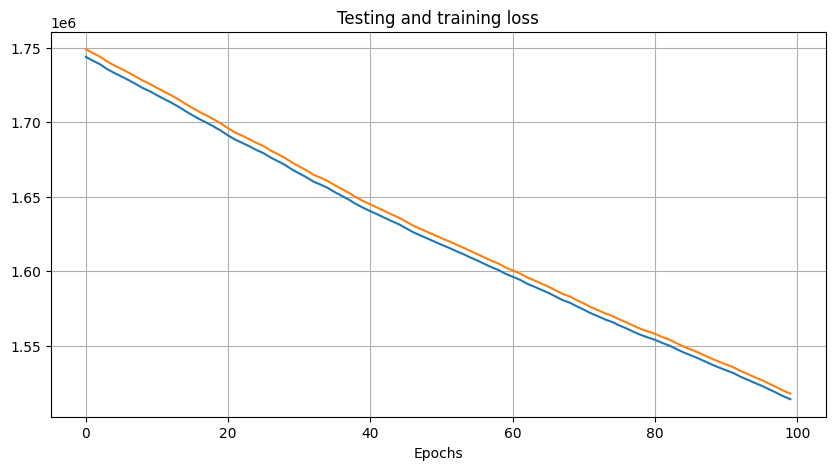

In [38]:
LENGTH = 10
train_dataset = fib_dataset(count=1000, length=LENGTH, seed=1234)
test_dataset = fib_dataset(count=200, length=LENGTH, seed=5678)

model = FibRNN(2) # two hidden layers

EPOCHS = 100
SAMPLES = 15
loss_function = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.01)
train_loss = torch.zeros(EPOCHS)
test_loss = torch.zeros(EPOCHS)

for epoch in range(EPOCHS):
    batch = torch.tensor(random.sample(range(train_dataset.shape[0]), k=SAMPLES))

    init_hidden_state = torch.zeros((1, SAMPLES, model.hidden_size))

    input = train_dataset[batch, :-1, ...]
    expected_output = train_dataset[batch, 1:, ...]

    optimiser.zero_grad()
    output, hidden_state_output = model(input, init_hidden_state)
    loss = loss_function(output, expected_output)
    loss.backward()
    optimiser.step()

    with torch.no_grad():
        train_output, _ = model(train_dataset[:, :-1, :], torch.zeros((1, train_dataset.shape[0], model.hidden_size)))
        train_loss[epoch] = loss_function(train_output, train_dataset[:, 1:, :])
        test_output, _ = model(test_dataset[:, :-1, :], torch.zeros((1, test_dataset.shape[0], model.hidden_size)))
        test_loss[epoch] = loss_function(test_output, test_dataset[:, 1:, :])


fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Testing and training loss')
ax.set_xlabel('Epochs')
ax.grid()
ax.plot(train_loss, label='Training loss')
ax.plot(test_loss, label='Testing loss')

plt.show()

## question 1

Epoch 1/100, Loss: 0.05743468075990677
Epoch 2/100, Loss: 0.035596596375107765
Epoch 3/100, Loss: 0.024779965355992317
Epoch 4/100, Loss: 0.0168539098277688
Epoch 5/100, Loss: 0.012700664326548577
Epoch 6/100, Loss: 0.011230049543082715
Epoch 7/100, Loss: 0.010698011349886656
Epoch 8/100, Loss: 0.010352407060563564
Epoch 9/100, Loss: 0.009567040856927634
Epoch 10/100, Loss: 0.007800522241741419
Epoch 11/100, Loss: 0.006189934723079204
Epoch 12/100, Loss: 0.004673646688461304
Epoch 13/100, Loss: 0.0034180018212646244
Epoch 14/100, Loss: 0.002600296949967742
Epoch 15/100, Loss: 0.002080205481033772
Epoch 16/100, Loss: 0.0017454494605772196
Epoch 17/100, Loss: 0.0015228389436379075
Epoch 18/100, Loss: 0.001354937021387741
Epoch 19/100, Loss: 0.0012332277791574598
Epoch 20/100, Loss: 0.0011311647412367166
Epoch 21/100, Loss: 0.0010502535570412874
Epoch 22/100, Loss: 0.0009924883919302373
Epoch 23/100, Loss: 0.0009333650488406419
Epoch 24/100, Loss: 0.0008959762915037573
Epoch 25/100, Loss:

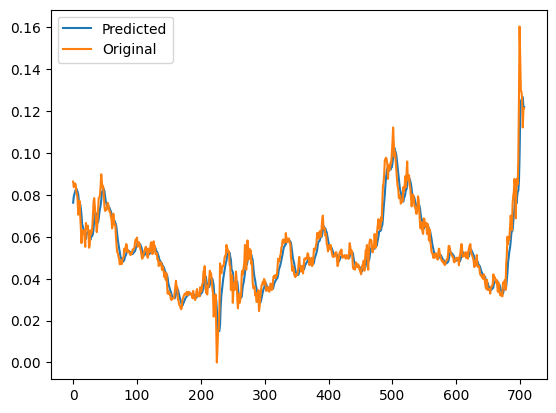

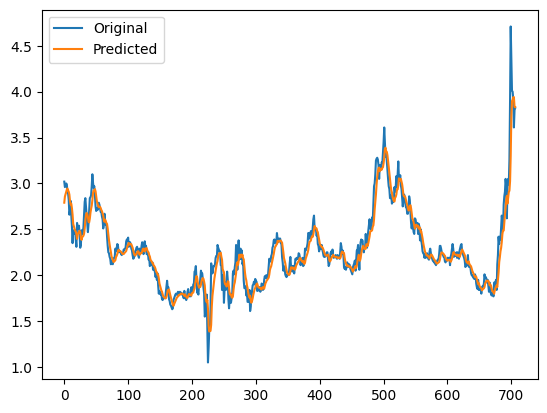

In [40]:
# error in lab code, not storing and indexing values properly

import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn

df = pd.read_csv("./prices/daily_prices.csv")
df = df.dropna()
y = df['Price'].values
x = np.arange(1, len(y) + 1, 1) 

minm = y.min()
maxm = y.max()

y = (y - minm) / (maxm - minm)  
Sequence_Length = 10
X = []
Y = []

for i in range(0, len(y) - Sequence_Length):
    list1 = []
    for j in range(i, i + Sequence_Length):
        list1.append(y[j])
    X.append(list1)
    Y.append(y[i + Sequence_Length])

X = np.array(X)
Y = np.array(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42, shuffle=False)

class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len

train_dataset = NGTimeSeries(x_train, y_train)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=256)

test_dataset = NGTimeSeries(x_test, y_test)

class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        output, _status = self.rnn(x)
        output = output[:, -1, :] 
        output = self.fc1(torch.relu(output))
        return output

model = RNNModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_idx, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.view(-1, Sequence_Length, 1)
        optimizer.zero_grad()  

        y_pred = model(inputs)

        loss = criterion(y_pred, labels.view(-1, 1))  
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

model.eval()
test_inputs = torch.tensor(x_test, dtype=torch.float32).view(-1, Sequence_Length, 1)  # reshape
test_labels = torch.tensor(y_test, dtype=torch.float32)

with torch.no_grad():
    test_pred = model(test_inputs)

plt.plot(test_pred.detach().numpy(), label='Predicted')
plt.plot(test_labels.numpy(), label='Original')
plt.legend()
plt.show()

y_rescaled = y_test * (maxm - minm) + minm
y_pred_rescaled = test_pred.detach().numpy().flatten() * (maxm - minm) + minm

plt.plot(y_rescaled, label='Original')
plt.plot(range(len(y_rescaled) - len(y_pred_rescaled), len(y_rescaled)), y_pred_rescaled, label='Predicted')
plt.legend()
plt.show()


## question 2

category = Vietnamese
category = French
category = Vietnamese
category = Dutch
category = Greek
category = Spanish
category = Spanish
category = Chinese
category = Vietnamese
category = Scottish
('Italian', 14)
Iter5000,  Loss 2.8357791900634766, Guess German, n (Scottish)
Iter10000,  Loss 3.1050126552581787, Guess Japanese, n (Italian)
Iter15000,  Loss 2.4360740184783936, Guess Arabic, n (Irish)
Iter20000,  Loss 3.2980384826660156, Guess German, n (Polish)
Iter25000,  Loss 1.4054081439971924, Guess Polish, n (Czech)
Iter30000,  Loss 1.1162973642349243, Guess Vietnamese, y
Iter35000,  Loss 1.0404584407806396, Guess Chinese, y
Iter40000,  Loss 3.498586893081665, Guess Chinese, n (Japanese)
Iter45000,  Loss 2.5221238136291504, Guess Korean, n (Chinese)
Iter50000,  Loss 2.2268450260162354, Guess Spanish, n (Italian)
Iter55000,  Loss 0.2992154359817505, Guess Czech, y
Iter60000,  Loss 1.428039789199829, Guess Portuguese, n (Spanish)
Iter65000,  Loss 0.04126863554120064, Guess Russian, y
It

/tmp/ipykernel_89935/3645209561.py:180: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_cats, rotation=90)
/tmp/ipykernel_89935/3645209561.py:181: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_cats)


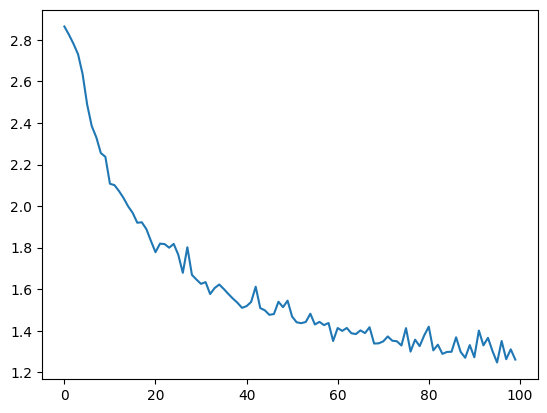

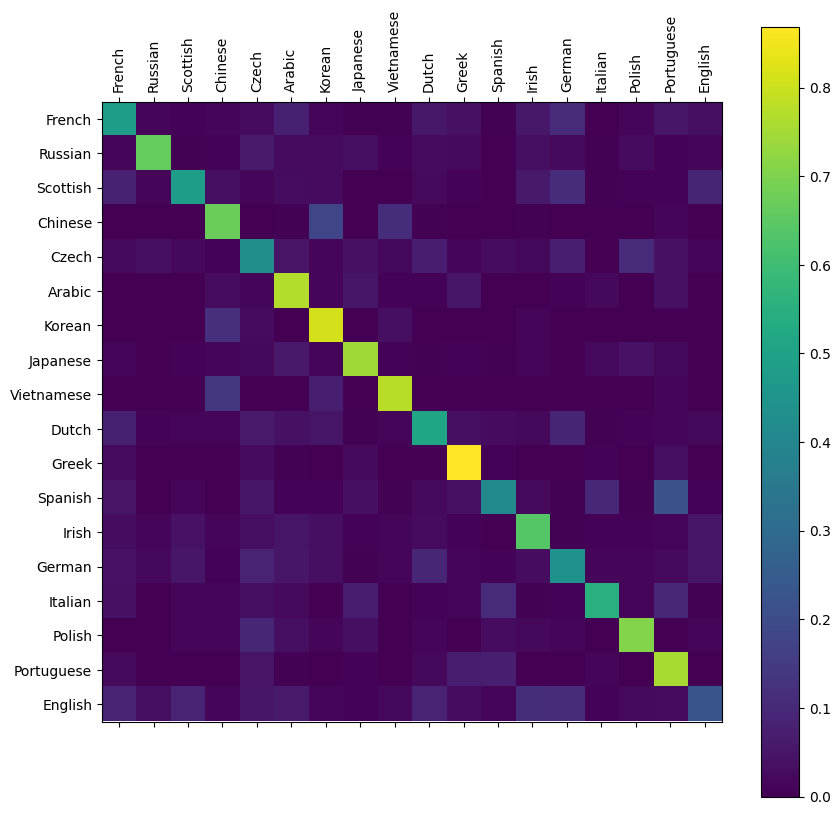


> Aggelen
(-0.24) Dutch
(-2.99) English
(-3.12) French

> Accardo
(-0.89) Portuguese
(-1.17) Spanish
(-1.47) Italian

> Ferreiro
(-0.49) Portuguese
(-1.79) Italian
(-1.87) Spanish


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# File reading
def printFiles(path):
    return glob.glob(path)

all_let = string.ascii_letters + " .,;'"
n_let = len(all_let)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_let
    )

cat_line = {}
all_cats = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in printFiles('./data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_cats.append(category)
    lines = readLines(filename)
    cat_line[category] = lines

n_categories = len(all_cats)

def letterToIndex(letter):
    return all_let.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_let)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_let)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_let, n_hidden, n_categories)

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_cats)
    line = randomChoice(cat_line[category])
    category_tensor = torch.tensor([all_cats.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_cats[category_i], category_i

output = torch.randn(1, n_categories)  
print(categoryFromOutput(output))

criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'y' if guess == category else f'n ({category})'
        print(f'Iter {iter},  Loss {loss}, Guess {guess}, {correct}')

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


plt.figure()
plt.plot(all_losses)

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_cats.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

figsize = (10, 10)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_cats, rotation=90)
ax.set_yticklabels([''] + all_cats)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_cats[category_index]))
            predictions.append([value, all_cats[category_index]])

predict('Aggelen')
predict('Accardo')
predict('Ferreiro')


## question 3

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, input_size)
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_seq, hidden_state):
        embedding = self.embedding(input_seq)
        output, hidden_state = self.rnn(embedding, hidden_state)
        output = self.decoder(output)
        return output, (hidden_state[0].detach(), hidden_state[1].detach())
    
def train():
    hidden_size = 512   
    seq_len = 100       
    num_layers = 3      
    lr = 0.002          
    epochs = 10          
    op_seq_len = 200    
    load_chk = False    
    save_path = "./preTrained/CharRNN_shakespeare.pth"
    data_path = "./data/shakespeare.txt"
    
    # load the text file
    data = open(data_path, 'r').read()
    chars = sorted(list(set(data)))
    data_size, vocab_size = len(data), len(chars)
    print("----------------------------------------")
    print("Data has {} characters, {} unique".format(data_size, vocab_size))
    print("----------------------------------------")
    
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    ix_to_char = { i:ch for i,ch in enumerate(chars) }
    
    data = list(data)
    for i, ch in enumerate(data):
        data[i] = char_to_ix[ch]
    
    data = torch.tensor(data).to(device)
    data = torch.unsqueeze(data, dim=1)
    
    rnn = RNN(vocab_size, vocab_size, hidden_size, num_layers).to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
    
    for i_epoch in range(1, epochs+1):
        
        data_ptr = np.random.randint(100)
        n = 0
        running_loss = 0
        hidden_state = None
        
        while True:
            input_seq = data[data_ptr : data_ptr+seq_len]
            target_seq = data[data_ptr+1 : data_ptr+seq_len+1]
            
            output, hidden_state = rnn(input_seq, hidden_state)
            
            loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq))
            running_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            data_ptr += seq_len
            n +=1
            
            if data_ptr + seq_len + 1 > data_size:
                break
            
        print("Epoch: {0} \t Loss: {1:.8f}".format(i_epoch, running_loss/n))
        torch.save(rnn.state_dict(), save_path)
        
        data_ptr = 0
        hidden_state = None
        
        rand_index = np.random.randint(data_size-1)
        input_seq = data[rand_index : rand_index+1]
        
        print("----------------------------------------")
        while True:
            output, hidden_state = rnn(input_seq, hidden_state)
            
            output = F.softmax(torch.squeeze(output), dim=0)
            dist = Categorical(output)
            index = dist.sample()
            
            print(ix_to_char[index.item()], end='')
            
            input_seq[0][0] = index.item()
            data_ptr += 1
            
            if data_ptr > op_seq_len:
                break
            
        print("\n----------------------------------------")



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test():
    
    hidden_size = 512   
    num_layers = 3      
    op_seq_len = 1000   
    
    load_path = "./preTrained/CharRNN_shakespeare.pth"
    data_path = "./data/shakespeare.txt"
    
#    load_path = "./preTrained/CharRNN_sherlock.pth"
#    data_path = "./data/sherlock.txt"
    
    data = open(data_path, 'r').read()
    chars = sorted(list(set(data)))
    data_size, vocab_size = len(data), len(chars)
    print("----------------------------------------")
    print("Data has {} characters, {} unique".format(data_size, vocab_size))
    print("----------------------------------------")
    
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    ix_to_char = { i:ch for i,ch in enumerate(chars) }
    
    data = list(data)
    for i, ch in enumerate(data):
        data[i] = char_to_ix[ch]
    
    data = torch.tensor(data).to(device)
    data = torch.unsqueeze(data, dim=1)
    
    rnn = RNN(vocab_size, vocab_size, hidden_size, num_layers).to(device)
    rnn.load_state_dict(torch.load(load_path))
    print("Model loaded successfully !!")
    
    data_ptr = 0
    hidden_state = None
    
    rand_index = np.random.randint(data_size - 11)
    input_seq = data[rand_index : rand_index + 9]
    
    _, hidden_state = rnn(input_seq, hidden_state)
    
    input_seq = data[rand_index + 9 : rand_index + 10]
    
    print("----------------------------------------")
    while True:
        output, hidden_state = rnn(input_seq, hidden_state)
        
        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample().item()
        
        print(ix_to_char[index], end='')
        
        input_seq[0][0] = index
        data_ptr += 1
        
        if data_ptr  > op_seq_len:
            break
        
    print("\n----------------------------------------")
   
if __name__ == '__main__':
    train()
    test()

----------------------------------------
Data has 3801089 characters, 66 unique
----------------------------------------
Epoch: 1 	 Loss: 1.43268088
----------------------------------------
w, and of
practions are now; and Gldy Fluers, in Highs
Should put enamy divers; rass your majesty's
hands, loted the kingly as 'tis mortals.
For chasty les any soulment possessed the
clouchief but forc
----------------------------------------
Epoch: 2 	 Loss: 1.29835784
----------------------------------------
.
Tell the beard, the forals,
Do new gladly been him.

KING HENRY V:
How cross?

FLUELLEN:
And down, this is for that. If he please
treason, is none as is fare. Which came in your
shortly stones, de Ch
----------------------------------------
Epoch: 3 	 Loss: 1.27255375
----------------------------------------
age
would have to the pride stage's unvoxe more de in us.

FLUELLEN:
The Signon, errte an help I shall feel for the king?

KING HENRY V:
Good wholesome most uncle! adieu, so much dead
to